In [3]:
!pip install netcdf4

You should consider upgrading via the 'C:\Users\zlukich\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [110]:
import netCDF4 as nc
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
pd.options.mode.chained_assignment = None  # default='warn'


# Helping functions

In [2]:
def get_neighbours(df,x,y):
    
    result = pd.DataFrame()
    
    df_cell = df.loc[(df["x"] ==x) & (df["y"] ==y)]
    
    
    new_row_right = df.loc[(df["x"] ==x+1) & (df["y"] ==y)]
   #print(new_row_right)
    if(len(new_row_right) == 0):
        new_row_right = pd.DataFrame({"x" : [x+1 for i in range(df_cell.shape[0])],
                                      "y" : [y for i in range(df_cell.shape[0])],
                                      "emission_value" : [0 for i in range(df_cell.shape[0])],
                                      "hour" : df_cell["hour"].values ,
                                      "nb_type" : ["nbr" for i in range(df_cell.shape[0])]})
    else:
        new_row_right["nb_type"] = "nbr"
    
    
    new_row_left = df.loc[(df["x"] ==x-1) & (df["y"] ==y)]
    if(len(new_row_left) == 0):
        new_row_left = pd.DataFrame({"x" : [x-1 for i in range(df_cell.shape[0])],
                                      "y" : [y for i in range(df_cell.shape[0])],
                                      "emission_value" : [0 for i in range(df_cell.shape[0])],
                                      "hour" : df_cell["hour"].values ,
                                      "nb_type" : ["nbl" for i in range(df_cell.shape[0])]})
    else:
        new_row_left["nb_type"] = "nbl"
    
    
    new_row_up = df.loc[(df["x"] ==x) & (df["y"] ==y-1)]
    if(len(new_row_up) == 0):
        new_row_up = pd.DataFrame({"x" : [x for i in range(df_cell.shape[0])],
                                      "y" : [y-1 for i in range(df_cell.shape[0])],
                                      "emission_value" : [0 for i in range(df_cell.shape[0])],
                                      "hour" : df_cell["hour"].values ,
                                      "nb_type" : ["nbu" for i in range(df_cell.shape[0])]})
    else:
        new_row_up["nb_type"] = "nbu"
    
    
    new_row_down = df.loc[(df["x"] ==x) & (df["y"] ==y+1)]
    if(len(new_row_down) == 0):
        new_row_down = pd.DataFrame({"x" : [x for i in range(df_cell.shape[0])],
                                      "y" : [y+1 for i in range(df_cell.shape[0])],
                                      "emission_value" : [0 for i in range(df_cell.shape[0])],
                                      "hour" : df_cell["hour"].values ,
                                      "nb_type" : ["nbd" for i in range(df_cell.shape[0])]})
    else:
        new_row_down["nb_type"] = "nbd"
    result = pd.concat([new_row_right,new_row_left,new_row_up,new_row_down])
    return result



def add_neighbours(df,x,y):
    '''
    
        df_cell: adds neighbours to specific cell
    '''
    df_cell = df.loc[(df["x"] ==x) & (df["y"] ==y)]
    
    #print(df_cell)
    neighbours = get_neighbours(df,x,y)
    
    neighbours_right = neighbours.loc[neighbours["nb_type"] == "nbr"]
    neighbours_left = neighbours.loc[neighbours["nb_type"] == "nbl"]
    neighbours_up = neighbours.loc[neighbours["nb_type"] == "nbu"]
    neighbours_down = neighbours.loc[neighbours["nb_type"] == "nbd"]
    
    #print(neighbours_right)
    try:
        df_to_append = pd.DataFrame({"nbr":neighbours_right["emission_value"].values,
                                    "nbl":neighbours_left["emission_value"].values,
                                    "nbu":neighbours_up["emission_value"].values,
                                    "nbd":neighbours_down["emission_value"].values})
    except:
        print("hello")
        #print(neighbours)
        #print(neighbours_right)
        #print(neighbours_left)
        #print(neighbours_up)
        #print(neighbours_down)
    #print(df_to_append)
    df_to_append = df_to_append.reset_index(drop=True)
    df_cell = df_cell.reset_index(drop=True)
    result= pd.concat([df_cell,df_to_append],axis = 1)
    return result

def complete_df_with_neighbours(df):
    '''
        
    '''
    maximal_x = max(df["x"])
    maximal_y = max(df["y"])
    #print(df.shape[0])
    result = pd.DataFrame()
    for i in range(maximal_x+1):
        for j in range(maximal_y+1):
            df_cell = add_neighbours(df,i ,j )
            #print(df_cell)
            result = pd.concat([result,df_cell])
    return result
    

# Reading .nc files

In [4]:
ds = nc.Dataset("../data/photoshade_6km10m_lod2_chemistry.nc")

In [5]:
ds["emission_values"][0,0,:,:,0].data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Save information as CSV file

In [6]:
pd_15hour_3species = pd.DataFrame(ds["emission_values"][15,0,:,:,2].data)

In [7]:
pd_15hour_melted = pd.melt(pd_15hour_3species,var_name = "y",value_name = "emission_value")

In [8]:
pd_15hour_melted["x"] = [i%672 for i in range(pd_15hour_melted.shape[0])]

In [9]:
pd_15hour_melted

,y,emission_value,x
0,0,0.0,0
1,0,0.0,1
2,0,0.0,2
3,0,0.0,3
4,0,0.0,4
...,...,...,...
451579,671,0.0,667
451580,671,0.0,668
451581,671,0.0,669
451582,671,0.0,670


In [10]:
new_cols_order = ["x","y","emission_value"]
pd_15hour_melted = pd_15hour_melted[new_cols_order]

### DF concatenation

In [79]:
result_1species = pd.DataFrame()
xrange = [i for i in range(50)] # Subsetting specific grid part
yrange = [i for i in range(50)] # Subsetting specific grid part
for i in range(48):
    pd_ihour_3species = pd.DataFrame(ds["emission_values"][i,0,yrange,xrange,1].data)
    pd_ihour_3species = pd.melt(pd_ihour_3species,var_name = "y",value_name = "emission_value")
    pd_ihour_3species["x"] = [i%len(yrange) for i in range(pd_ihour_3species.shape[0])]
    pd_ihour_3species["hour"] = i
    result_1species= pd.concat([result_1species,pd_ihour_3species])


In [80]:
new_cols_order = ["x","y","hour","emission_value"]
result_1species= result_1species[new_cols_order]
result_1species

,x,y,hour,emission_value
0,0,0,0,0.0
1,1,0,0,0.0
2,2,0,0,0.0
3,3,0,0,0.0
4,4,0,0,0.0
...,...,...,...,...
2495,45,49,47,0.0
2496,46,49,47,0.0
2497,47,49,47,0.0
2498,48,49,47,0.0


In [85]:
result_1species.describe()

,x,y,hour,emission_value
count,120000.00000,120000.00000,120000.000000,120000.000000
mean,24.50000,24.50000,23.500000,0.000269
std,14.43093,14.43093,13.853457,0.001600
min,0.00000,0.00000,0.000000,0.000000
25%,12.00000,12.00000,11.750000,0.000000
50%,24.50000,24.50000,23.500000,0.000000
75%,37.00000,37.00000,35.250000,0.000000
max,49.00000,49.00000,47.000000,0.032083


### Lets look into 65,65 cell specifically

In [269]:
(x,y) = (75,71)
df_cell = result_0species.loc[(result_0species["x"] == x) & (result_0species["y"] == y)]
df_cell

,x,y,hour,emission_value
7175,75,71,0,0.000958
7175,75,71,1,0.001685
7175,75,71,2,0.005498
7175,75,71,3,0.040410
7175,75,71,4,0.068488
7175,75,71,5,0.073122
7175,75,71,6,0.067746
7175,75,71,7,0.072280
7175,75,71,8,0.064559
7175,75,71,9,0.065540


# PALM Output files

### Download

In [23]:
output_emissions_no2_0 = nc.Dataset("../data/photoshade_6km10m_lod2_av_masked_M01.000.nc")
output_emissions_no2_1 = nc.Dataset("../data/photoshade_6km10m_lod2_av_masked_M01.001.nc")
output_emissions_no2_2 = nc.Dataset("../data/photoshade_6km10m_lod2_av_masked_M01.002.nc")
output_emissions_no2_3 = nc.Dataset("../data/photoshade_6km10m_lod2_av_masked_M01.003.nc")
output_emissions_no2_4 = nc.Dataset("../data/photoshade_6km10m_lod2_av_masked_M01.004.nc")

output_emissions_no2_list = [output_emissions_no2_0,
                             output_emissions_no2_1,
                             output_emissions_no2_2,
                             output_emissions_no2_3,
                             output_emissions_no2_4,]

In [24]:
output_emissions_no2_0

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: PALM 21.10  run: photoshade_6km10m_lod2.00  host: basit  2022-06-17 16:48:38
    Conventions: CF-1.7
    creation_time: 2022-06-17 16:48:38 +02
    data_content: podsmasked
    version: 1
    origin_time: 2017-07-17 00:00:00 +00
    origin_lat: 52.48975372314453
    origin_lon: 13.273119926452637
    origin_x: 382751.5
    origin_y: 5816914.0
    origin_z: 25.382944107055664
    rotation_angle: 0.0
    dependencies: 
    history: 
    author: Basit Khan, basit.khan@kit.edu
    contact_person: 
    institution: Karlsruher Institute of Technology, IMK-IFU, Alpin Campus, GaPa
    acronym: KIT/IMK-IFU
    campaign: summer iop02
    location: Berlin
    site: Berlin Mitte
    source: PALM 21.10
    references: text
    keywords: text
    licence: 
    comment: created with palm_csd
    time_avg:  3600.0 s avg
    VAR_LIST: ;kc_NO;kc_NO2;kc_O3;kc_PM10;
    dimensions(sizes): time(3), ku_above_sur

In [128]:
# or in multifile dataset(doesn't work)
# f = nc.MFDataset("../data/photoshade_6km10m_lod2_av_masked_M01*nc")

ValueError: MFNetCDF4 only works with NETCDF3_* and NETCDF4_CLASSIC formatted files, not NETCDF4

In [21]:
output_emissions_no2_4["time"][:].data

array([147600.22200114, 151200.04600114, 154800.00500114, 158400.10700118,
       162000.19300133, 165600.31400149, 169200.50900165, 172800.08700181])

### Need to reformat to match input emissions grid dataframe

In [98]:
output_emissions_no2_values = []


In [129]:
output_emissions_no2_0["kc_NO2"][0,0,:,:].data

array([[ 1.01497509e-02,  1.01466635e-02,  1.01436023e-02, ...,
         1.01645896e-02,  1.01506347e-02,  1.01479013e-02],
       [-9.99900000e+03,  1.01435138e-02,  1.01412162e-02, ...,
         1.01605533e-02,  1.01453867e-02,  1.01415450e-02],
       [-9.99900000e+03, -9.99900000e+03,  1.01285819e-02, ...,
         1.01507641e-02,  1.01363352e-02,  1.01333056e-02],
       ...,
       [ 1.01782894e-02,  1.01692211e-02,  1.01732612e-02, ...,
         1.01743583e-02,  1.01781739e-02,  1.01791173e-02],
       [ 1.01683699e-02,  1.01540107e-02,  1.01614557e-02, ...,
         1.01666236e-02,  1.01637840e-02,  1.01728830e-02],
       [ 1.01574846e-02,  1.01480503e-02, -9.99900000e+03, ...,
         1.01642087e-02,  1.01578943e-02, -9.99900000e+03]], dtype=float32)

In [124]:
result_1species_output = pd.DataFrame()
xrange = [i for i in range(50)] # Subsetting specific grid part
yrange = [i for i in range(50)] # Subsetting specific grid part
pollutant = "kc_NO"
for output_table in output_emissions_no2_list:
    timebins = (output_table["time"][:].data/3600).astype(int) # getting hours array (after conversion from seconds to hours)
    for i in range(len(timebins)):
        pd_ihour_1species = pd.DataFrame(output_table[pollutant][i,0,yrange,xrange].data)#(netcdf format [hour,y,x])
        pd_ihour_1species = pd.melt(pd_ihour_1species,var_name = "y",value_name = "emission_value")
        pd_ihour_1species["x"] = [i%len(yrange) for i in range(pd_ihour_1species.shape[0])]
        pd_ihour_1species["hour"] = timebins[i]
        result_1species_output= pd.concat([result_1species_output,pd_ihour_1species])

In [125]:
result_1species_output.replace(-9999,0,inplace=True) # because strange values where there are no pollutants
result_1species_output = result_1species_output[["x","y","hour","emission_value"]]
result_1species_output

,x,y,hour,emission_value
0,0,0,1,8.815081e-05
1,1,0,1,0.000000e+00
2,2,0,1,0.000000e+00
3,3,0,1,0.000000e+00
4,4,0,1,9.603330e-05
...,...,...,...,...
2495,45,49,48,3.324763e-09
2496,46,49,48,2.766754e-09
2497,47,49,48,2.241912e-09
2498,48,49,48,1.703787e-09


In [106]:
result_1species_output

,x,y,hour,out_emission_value
0,0,0,1,8.815081e-05
1,1,0,1,0.000000e+00
2,2,0,1,0.000000e+00
3,3,0,1,0.000000e+00
4,4,0,1,9.603330e-05
...,...,...,...,...
2495,45,49,48,3.324763e-09
2496,46,49,48,2.766754e-09
2497,47,49,48,2.241912e-09
2498,48,49,48,1.703787e-09


# Plot pollution distribution

In [136]:
def make_heatmap_from_pd(result_dataframe,hour):
    result_1specieshour = result_dataframe.loc[result_dataframe["hour"] == hour]
    result_1specieshour = result_1specieshour[["x","y","emission_value"]]
    x, y = result_1specieshour[["x", "y"]].max() + 1
    v = result_1specieshour["emission_value"].to_numpy().reshape((x, y))
    indices = result_1specieshour[["x", 'y']].to_numpy().T

    v = np.tile(np.nan, indices.max(axis=1) + 1)
    v[tuple(indices)] = result_1specieshour["emission_value"]
    ax = sns.heatmap(v)
    plt.show()

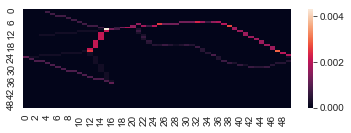

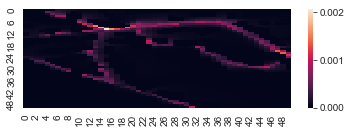

In [150]:
#plotting
hour = 45
plt.subplot(2,1,1)
make_heatmap_from_pd(result_1species,hour)
plt.subplot(2,1,2)
make_heatmap_from_pd(result_1species_output,hour)



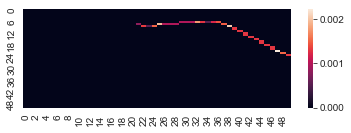

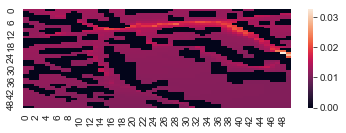

In [172]:
#Plot ranges
xrange = [i for i in range(0,50,1)]
yrange = [i for i in range(0,50,1)]
#Data preparing
in_data = ds["emission_values"][26,0,yrange,xrange,1].data          #[hour,z,y,x,nspecies]
out_data = pd.DataFrame(output_emissions_no2_3["kc_NO"][0,0,yrange,xrange].data) #[hour,ku_surf_above,y,x]
out_data[out_data ==-9999] = 0
#plotting
plt.subplot(2,1,1)
ax = sns.heatmap(in_data)
plt.show()
plt.subplot(2,1,2)
ax = sns.heatmap(out_data)
plt.show()

In [ ]:
output_emissions_no2_3["time"]

# Outputing relevant information in csvs

In [151]:
completed_1species = complete_df_with_neighbours(result_1species)
completed_1species

,x,y,hour,emission_value,nbr,nbl,nbu,nbd
0,0,0,0,0.0,0.0,0.0,0.0,0.0
1,0,0,1,0.0,0.0,0.0,0.0,0.0
2,0,0,2,0.0,0.0,0.0,0.0,0.0
3,0,0,3,0.0,0.0,0.0,0.0,0.0
4,0,0,4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
43,49,49,43,0.0,0.0,0.0,0.0,0.0
44,49,49,44,0.0,0.0,0.0,0.0,0.0
45,49,49,45,0.0,0.0,0.0,0.0,0.0
46,49,49,46,0.0,0.0,0.0,0.0,0.0


In [152]:
completed_1species_out = complete_df_with_neighbours(result_1species_output)
completed_1species_out

,x,y,hour,emission_value,nbr,nbl,nbu,nbd
0,0,0,1,8.815081e-05,0.0,0.000000e+00,0.000000e+00,0.000087
1,0,0,2,3.298550e-05,0.0,0.000000e+00,0.000000e+00,0.000028
2,0,0,3,5.620945e-05,0.0,0.000000e+00,0.000000e+00,0.000048
3,0,0,4,5.168101e-04,0.0,0.000000e+00,0.000000e+00,0.000506
4,0,0,5,4.583161e-03,0.0,0.000000e+00,0.000000e+00,0.004548
...,...,...,...,...,...,...,...,...
43,49,49,44,1.665753e-06,0.0,1.603733e-06,1.693905e-06,0.000000
44,49,49,45,5.869731e-06,0.0,6.138296e-06,6.684226e-06,0.000000
45,49,49,46,8.536082e-07,0.0,9.832816e-07,8.831243e-07,0.000000
46,49,49,47,5.267595e-07,0.0,5.749978e-07,5.290955e-07,0.000000


In [164]:
completed_1species.to_csv("../data/result1_species_in.csv",index=False,sep =";",encoding='utf-8', float_format='%.15f')
completed_1species_out.to_csv("../data/result1_species_out.csv",index=False,sep =";",encoding='utf-8', float_format='%.15f')
